<h1> Import Modules and Data </h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

from helper_functions import * # helper_functions defined in helper_functions.py

data = get_data()
zcmb, mb, dmbb, mu_LCDM, distances, velocities = filter_data(data)

<h1> Plot Base Data </h1>

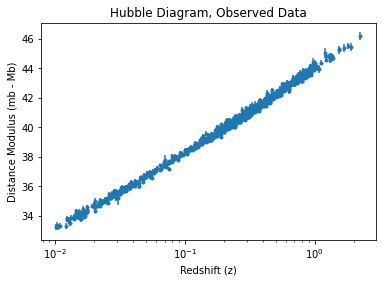

In [3]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel("Distance Modulus (mb - Mb)")
ax1.set_title('Hubble Diagram, Observed Data')
ax1.errorbar(zcmb, mu_LCDM, fmt='.', yerr=dmbb)
ax1.set_xscale('log') # Optional, but is how most models are shown

<h1> Plotting Different Parameter Sets </h1>

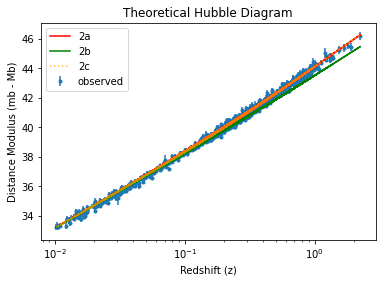

In [17]:
# Plot observed data
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel("Distance Modulus (mb - Mb)")
ax1.set_title('Theoretical Hubble Diagram')
ax1.errorbar(zcmb, mu_LCDM, yerr=dmbb, fmt='.', label='observed', zorder=1)
ax1.set_xscale('log') # Optional, but is how most models are shown

# Plot set 2a
H0 = 70 # km/s
omega_m = 0.3
omega_l = 0.7
cosmo_a = FlatLambdaCDM(H0, omega_m)
distance_moduluses_a = cosmo_a.distmod(zcmb).value
ax1.plot(zcmb, distance_moduluses_a, label='2a', color='red', zorder=2)

# Plot set 2b
H0 = 70 # km/s
omega_m = 1
omega_l = 1
cosmo_b = FlatLambdaCDM(H0, omega_m)
distance_moduluses_b = cosmo_b.distmod(zcmb).value
ax1.plot(zcmb, distance_moduluses_b, label='2b', color='green', zorder=3)

# Plot set 2c
H0 = 70 # km/s
omega_m = 0.3
omega_l = 0
cosmo_c = FlatLambdaCDM(H0, omega_m)
distance_moduluses_c = cosmo_c.distmod(zcmb).value
ax1.plot(zcmb, distance_moduluses_c, ':', label='2c', color='orange', alpha=0.7, zorder=4)

ax1.legend()
plt.show()

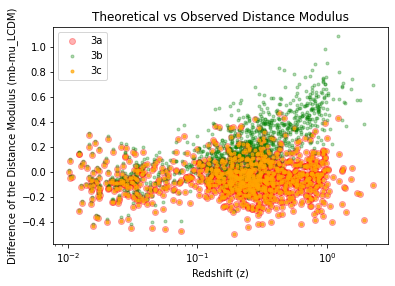

In [35]:
# Plot the differences between each set and the observed data
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.set_xlabel('Redshift (z)')
ax2.set_ylabel("Difference of the Distance Modulus (mb-mu_LCDM)")
ax2.set_title('Theoretical vs Observed Distance Modulus')
ax2.set_xscale('log') # Optional, but is how most models are shown

differences_a = get_differences(mu_LCDM, distance_moduluses_a)
ax2.scatter(zcmb, differences_a, marker='o',label='3a', color='red', alpha=0.3)

differences_b = get_differences(mu_LCDM, distance_moduluses_b)
ax2.scatter(zcmb, differences_b, marker='.', label='3b', color='green', alpha=0.3)

differences_c = get_differences(mu_LCDM, distance_moduluses_c)
ax2.scatter(zcmb, differences_c, marker='.', label='3c', color='orange', alpha=0.7)

ax2.legend()
plt.show()

<h1> Calculate Estimates Using Least Squared Error </h1>

H0: 71.79953377975276 +/- 0.22425160184871776
Omega_m: 0.2845392853174459 +/- 0.01254250381728956
Omega_l: 0.7154607146825541 +/- 0.01254250381728956


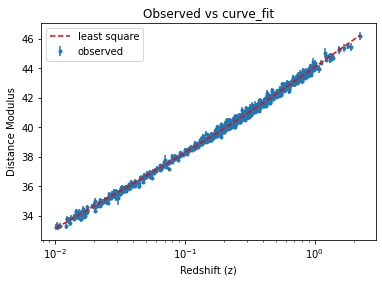

In [16]:
from scipy.optimize import curve_fit

# Returns the distance modulus using astropy
def objective(x, H0, omega_m):
    cosmo = FlatLambdaCDM(H0, omega_m)
    return cosmo.distmod(x).value

# Perform curve fit
popt, pcov = curve_fit(objective, zcmb, mu_LCDM, sigma=dmbb, bounds=([0, 0], [100, 1]), absolute_sigma=True)
err = np.sqrt(np.diag(pcov))

# Print the returned values
H0_ls, omega_m_ls = popt
omega_l_ls = 1 - omega_m_ls
print('H0: ' + str(H0_ls) + " +/- " + str(err[0]))
print('Omega_m: ' + str(omega_m_ls) + " +/- " + str(err[1]))
print('Omega_l: ' + str(omega_l_ls) + " +/- " + str(err[1]))

# x values are evenly spaced between smallest and largest z values
x_line = np.linspace(min(zcmb), max(zcmb), 100)
# Calculate the output for all x values
y_line = objective(x_line, H0_ls, omega_m_ls)

# Generate a plot of the observed data vs data calculated via least squared error
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.errorbar(zcmb, mu_LCDM, yerr=dmbb, fmt='.', label='observed', zorder=1)
ax1.plot(x_line, y_line, '--', color='red', label='least square', zorder=2)
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel("Distance Modulus")
ax1.set_title('Observed vs curve_fit')
ax1.set_xscale('log') # Optional, but is how most models are shown
plt.legend()
plt.show()

<h1>Calculate Estimates Using Maximum Likelihood Estimation</h1>

In [4]:
def log_likelihood(theta, x, y, yerr):
    H0, omega_m = theta
    
    cosmo = cosmo = FlatLambdaCDM(H0, omega_m)
    model = np.array(cosmo.distmod(x).value)
    
    sigma2 = np.square(yerr)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

H0: 71.79953777452991
Omega_m: 0.2845389813864452
Omega_m: 0.7154610186135548


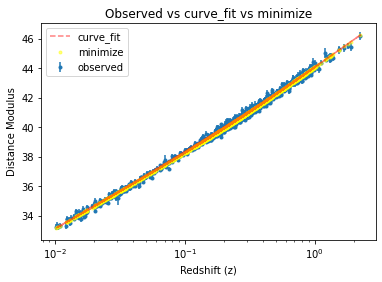

In [5]:
from scipy.optimize import minimize

# Perform minimize fit
nll = lambda *args: -log_likelihood(*args)
initial = np.array([H0_ls, omega_m_ls]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(np.array(zcmb), np.array(mu_LCDM), dmbb), bounds = ([0,100], [0,1]))

# Print the returned values
H0_ml, omega_m_ml = soln.x
omega_l_ml = 1 - omega_m_ml
print('H0: ' + str(H0_ml))
print('Omega_m: ' + str(omega_m_ml))
print('Omega_m: ' + str(omega_l_ml))

# x line is all z values
x_line = zcmb
# Calculate the output for all x values for both models
y_line_ls = objective(x_line, H0_ls, omega_m_ls)
y_line_ml = objective(x_line, H0_ml, omega_m_ml)

# Generate a plot of the observed data vs data calculated via both models
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.errorbar(zcmb, mu_LCDM, yerr=dmbb, fmt='.', label='observed', zorder=1)
ax1.plot(x_line, y_line_ls, '--', color='red', label='curve_fit', zorder=3, alpha=0.5)
ax1.plot(x_line, y_line_ml, '.', color='yellow', label='minimize', zorder=2, alpha=0.5)
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel("Distance Modulus")
ax1.set_title('Observed vs curve_fit vs minimize')
ax1.set_xscale('log') # Optional, but is how most models are shown
ax1.legend()
plt.show()

<h1> Calculate Estimates Using EMCEE </h1>

In [6]:
# Creates bounds for data
def log_prior(theta):
    H0, omega_m = theta
    if 0 < H0 < 100 and 0 < omega_m < 1:
        return 0
    return -np.inf

In [7]:
# Cobmines calculations with bounds
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [8]:
import emcee

pos = [H0_ml, omega_m_ml] + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(np.array(zcmb), np.array(mu_LCDM), dmbb))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:10<00:00, 19.96it/s]


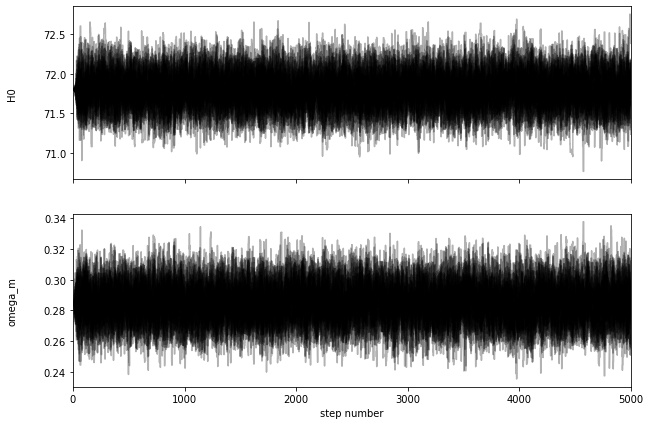

In [9]:
# Plots the parameters at each walker in the chain
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0", "omega_m"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [10]:
tau = sampler.get_autocorr_time()
print(tau)

[30.79950504 29.46113561]


In [11]:
# Discards first 100 values due to innacuracy of early training data
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


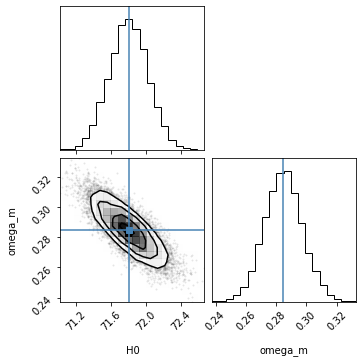

In [12]:
import corner

# Generate corner plot to display covariances between parameters
fig = corner.corner(
    flat_samples, labels=labels, truths=[H0_ls, omega_m_ls]
);

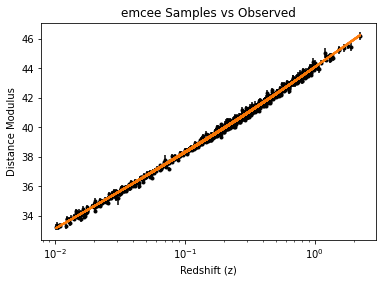

In [13]:
# Plots 100 random samples to display variance of distance modulus throughout walkers
fig1 = plt.figure()
ax1 = fig1.add_subplot()
inds = np.random.randint(len(flat_samples), size=100)
ax1.errorbar(zcmb, mu_LCDM, yerr=dmbb, fmt=".k", capsize=0, zorder=1)
for ind in inds:
    sample = flat_samples[ind]
    # calculate the output for the range
    y_line_emcee = objective(x_line, sample[0], sample[1])
    ax1.plot(x_line, y_line_emcee, "C1", alpha=0.1, zorder=2)
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel("Distance Modulus")
ax1.set_title('emcee Samples vs Observed')
ax1.set_xscale('log') # Optional, but is how most models are shown

In [17]:
from IPython.display import display, Math

# Print the returned values
emcee_vals = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    emcee_vals.append(mcmc[1])
    display(Math(txt))
print('omega_l ' + str(1-emcee_vals[1]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

omega_l 0.7152398304743817


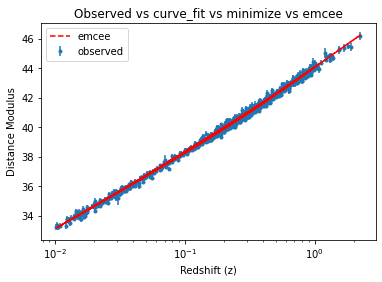

In [21]:
# x line is all z values
x_line = zcmb
# Calculate the output for all x values for both models
y_line_ls = objective(x_line, H0_ls, omega_m_ls)
y_line_ml = objective(x_line, H0_ml, omega_m_ml)
y_line_emcee = objective(x_line, emcee_vals[0], emcee_vals[1])

# Generate a plot of the observed data vs data calculated via all models
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.errorbar(zcmb, mu_LCDM, yerr=dmbb, fmt='.', label='observed', zorder=1)
#ax1.plot(x_line, y_line_ls, '.', color='green', label='curve_fit', zorder=3, alpha=0.5)
#ax1.plot(x_line, y_line_ml, '.', color='yellow', label='minimize', zorder=2, alpha=1)
ax1.plot(x_line, y_line_emcee, '--', color='red', label='emcee', zorder=4, alpha=1)
ax1.set_xlabel('Redshift (z)')
ax1.set_ylabel("Distance Modulus")
ax1.set_title('Observed vs curve_fit vs minimize vs emcee')
ax1.set_xscale('log') # Optional, but is how most models are shown
ax1.legend()
plt.show()